## Stock Dataset

In [ ]:
!pip install yfinance
!pip install mpld3

     |████████████████████████████████| 6.4 MB 7.1 MB/s 
     |████████████████████████████████| 62 kB 792 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 201 kB 5.0 MB/s 


In [ ]:
from torch.utils.data import Dataset, DataLoader
from typing import Union
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins
import torch
from torch.nn import MSELoss
from torch.optim import RMSprop
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math

In [ ]:
class StockPriceDataset(Dataset):
    def __init__(self, start_date: str="jj-mm-aaaa", end_date: str="jj-mm-aaaa", 
                 interval: int=1, nb_samples: int=20, transform=None,
                 file_dir: str="data/", csv_file: str=None):

        # If a local data file must be loaded:
        if csv_file is not None:
            self.root_dir = file_dir
            self.filename = csv_file
            with open(os.path.join(file_dir,csv_file), 'r') as file:
                dataset = pd.read_csv(file, sep=',', header='infer')

        else: # Data must be loaded on an online database:
            dataset = yf.download('^GSPC', start=start_date, end=end_date, interval=interval)

        self.data = dataset
        self.nb_samples = nb_samples
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data) - self.nb_samples

    def __getitem__(self, index, overlapping=True) -> Union[torch.Tensor, float]:
        # Load one sample more than nb_samples for normalizing, transform
        if overlapping:
          sample = self.data['Close'][index:index+self.nb_samples+2]
        else:
          sample = self.data['Close'][index*self.nb_samples:(index+1)*self.nb_samples+2]
        sample = torch.tensor(sample)
        if self.transform:
            sample = self.transform(sample)[1:]
        else:
            sample = sample[1:]
        
        label = sample[-1] # label is the last elem of sample
        sample = sample[:-1] # removes label from sample
        return sample, label
      
    def get_normalization_value(self, index):
        # Retrieve the normalization value from the last sample
        return self.data['Close'][index]


def normalize_by_last_unknown_price(sample: torch.Tensor) -> torch.Tensor:
    """Divides the whole stock price sample by the last unknown price w_{p*t-1}"""
    last_price = sample[0] # w_{pt-1}
    return sample/last_price

[*********************100%***********************]  1 of 1 completed
head of the dataset = Date
1950-01-03    16.66
1950-01-04    16.85
1950-01-05    16.93
1950-01-06    16.98
1950-01-09    17.08
Name: Close, dtype: float64

 Plot of the 'Close' data :
len dataset = 14799


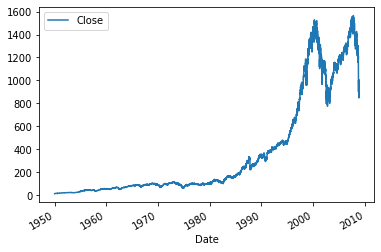

In [ ]:
VISUALIZE_DATASET = True
if VISUALIZE_DATASET:
  dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15,
                              transform=normalize_by_last_unknown_price)

  print("head of the dataset =", dataset.data.head()['Close'])

  print("\n Plot of the 'Close' data :")
  dataset.data.plot(None, ['Close'])

  print("len dataset =", len(dataset))

## Envirement 

In [ ]:
class Envirement : 
  def __init__(self):
      self.dataset = StockPriceDataset(start_date='1950-01-03', 
                              end_date='2008-11-16',
                              interval='1d',
                              nb_samples=15)
      
  def reset(self): 
    self.compteur = 0
    self.date = np.random.randint(len(self.dataset)) #date à partir de laquelle va commencer notre simulation
    observation,_ = self.dataset[self.date] #les 15 jours précedents présentent notre observation
    return observation


  def step(self,action): 
    obs, actuel = self.dataset[self.date]
    reward = 0
    if action == 0:  #ne pas vendre 
      if actuel - obs[-1] <= 0:
        reward = 1 
      else : 
        reward = -1
    elif action == 1:  #vendre 
      if actuel - obs[-1] <= 0:
        reward = -1 
      else : 
        reward = 1
    self.date += 1
    observation,_ = self.dataset[self.date]
    self.compteur += 1
    done = self.compteur >= 100
    info = dict()
    return observation, reward, done, info

## Test

In [ ]:
env = Envirement()
env.reset() #initialisation de l'env
reward_tot = 0
for _ in range(100):
  action = np.random.randint(0,2)
  observation, reward, done, info = env.step(action)
  reward_tot += reward
print(reward_tot)

[*********************100%***********************]  1 of 1 completed
-12


## Q learning

In [ ]:
from torch.nn import LSTM, Module, Dropout, ModuleList, Sigmoid

In [ ]:
class StockAI(Module):
     
    def __init__(self, input_size, lstm_size, num_layers, keep_prob) -> None:
        super().__init__()
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.lstm = LSTM(self.input_size, hidden_size=self.lstm_size, num_layers=self.num_layers,dropout=1-keep_prob, batch_first=True, proj_size=1)
        self.ac = Sigmoid()
    def forward(self,x):
        a, b = self.lstm(x)
        return self.ac(b[0])

In [ ]:
observation = env.reset()
print(observation)

tensor([107.4200, 107.5200, 108.2500, 108.0900, 108.3000, 108.8300, 108.9100,
        108.9900, 108.6300, 108.6000, 109.1400, 109.0200, 109.0200, 109.0200,
        109.3200], dtype=torch.float64)


In [ ]:
# Init of the model
model = StockAI(1,128,1,0.8)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19999999999999996 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
x = torch.unsqueeze(torch.unsqueeze(observation, 0), -1).float()
y = model(x)
action = 0 if y[0,0,0] < 0.5 else 1
print(action)

1


In [ ]:
#number of episode we will run
n_episodes = 100

#maximum of iteration per episode
max_iter_episode = 100

#initialize the exploration probability to 1
exploration_proba = 1

#exploartion decreasing decay for exponential decreasing
exploration_decreasing_decay = 0.001

# minimum of exploration proba
min_exploration_proba = 0.01

#discounted factor
gamma = 0.99

#learning rate
lr = 0.1

In [ ]:
replay_memory = list()